In [1]:
#Importing all the necessary Libraries
import numpy as np 
import pandas as pd 
import pywt
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.patheffects as PathEffects
import seaborn as sns
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

import keras
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 

Using TensorFlow backend.


In [2]:
#Attach the path to your dataset.
df=pd.read_csv('D:/Ear_Recurrent/eardataset.csv')
df=pd.read_csv('D:/Ear_Recurrent/eardataset.csv', encoding = "ISO-8859-1")

In [3]:
df_again = pd.read_csv('D:/Ear_Recurrent/eardataset.csv')
df_again.head(3)

,unnamed,subject,session,ear,buffer,block,data_0,data_1,data_2,data_3,...,data_650,data_651,data_652,data_653,data_654,data_655,data_656,data_657,data_658,data_659
0,40,0,0,left,A,40,0.000062,0.000063,0.000064,0.000067,...,-0.000046,-0.000048,-0.000049,-0.000051,-0.000052,-0.000052,-0.000053,-0.000053,-0.000052,-0.000051
1,41,0,0,left,A,41,0.000063,0.000064,0.000065,0.000067,...,-0.000039,-0.000040,-0.000042,-0.000043,-0.000044,-0.000044,-0.000044,-0.000044,-0.000044,-0.000042
2,42,0,0,left,A,42,0.000065,0.000066,0.000067,0.000069,...,-0.000042,-0.000043,-0.000045,-0.000046,-0.000047,-0.000047,-0.000047,-0.000047,-0.000047,-0.000045


In [4]:
df_again=df_again.drop(["unnamed", "session","ear","buffer","block"],axis=1)

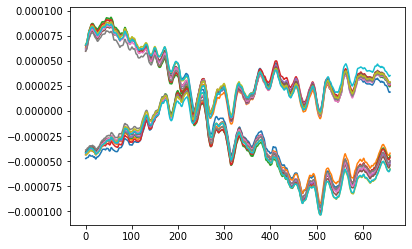

In [5]:
#View the signals in the dataset
for i in range(0,20):
    disp = df_again.iloc[i,1:661].values
    plt.plot(disp)
#10 consecutive signals are similar in a dataset while the next consecutive 10 are not.

In [6]:
#creating a dataFrame for the dataset
def subject0(subjectno, sessionno, earname, bufferid):
    dfu0=df.groupby(['subject', 'session', 'ear', 'buffer']).get_group((subjectno, sessionno, earname, bufferid)).iloc[-10:]
    return dfu0

x=subject0(34,0,'left','B')
x['subject'].iloc[0]
print(x.shape)
print(x)

(10, 666)
      unnamed  subject  session   ear buffer  block    data_0    data_1  \
2730    30662       34        0  left      B    272  0.000014  0.000013   
2731    30663       34        0  left      B    273  0.000014  0.000013   
2732    30664       34        0  left      B    274  0.000014  0.000013   
2733    30665       34        0  left      B    275  0.000015  0.000014   
2734    30666       34        0  left      B    276  0.000014  0.000013   
2735    30667       34        0  left      B    277  0.000015  0.000014   
2736    30668       34        0  left      B    278  0.000015  0.000014   
2737    30669       34        0  left      B    279  0.000013  0.000013   
2738    30670       34        0  left      B    280  0.000014  0.000014   
2739    30671       34        0  left      B    281  0.000015  0.000014   

        data_2    data_3  ...  data_650  data_651  data_652  data_653  \
2730  0.000013  0.000013  ...  0.000013  0.000012  0.000011  0.000011   
2731  0.000013  0.

In [7]:
#Creating Input and Labels DataFrame

allInputTEOAEsignalsAllSubjects = pd.DataFrame([])
allOutputLabelsAllSubjects = pd.DataFrame([])
for a in range(54):
    print(a)
    df1 = pd.DataFrame([])
    b=[0]              # sessions 0 and 1
    c=['left']   # ears 
    d=['A']          # buffers
    
    allFeatures =  pd.DataFrame([])
    allInputFeatures =  pd.DataFrame([])
    outputLabel =  pd.DataFrame([])
    fftValues =  pd.DataFrame([])
    psdValues =  pd.DataFrame([])
    autocorrValues = pd.DataFrame([])
        
    for q,r,s in [(q,r,s) for q in b for r in c for s in d]:
        
        # df1 contains all the 80 TEOAE signals of subject a
        df1 = df1.append(subject0(a,q,r,s))
        allInputFeatures = df1.iloc[:,6:]
    
    allInputTEOAEsignalsAllSubjects = pd.concat([allInputTEOAEsignalsAllSubjects.reset_index(drop=True),
                                                 allInputFeatures.reset_index(drop=True)], axis=0)
    # the following gets you the class label <= subject no.[0,1,2,...,53]
    outputLabel = df1.iloc[:,1] 
    print("OutputLabel:",outputLabel)
    #allOutputLabelsAllSubjects = allOutputLabelsAllSubjects.append(outputLabel)
    #append didn't work for output so using pd.cat instead
    allOutputLabelsAllSubjects = pd.concat([allOutputLabelsAllSubjects.reset_index(drop=True),
                                            outputLabel.reset_index(drop=True)], axis=0)
    print(allInputTEOAEsignalsAllSubjects.shape)
    print(allOutputLabelsAllSubjects.shape)


0
OutputLabel: 0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: subject, dtype: int64
(10, 660)
(10, 1)
1
OutputLabel: 80    1
81    1
82    1
83    1
84    1
85    1
86    1
87    1
88    1
89    1
Name: subject, dtype: int64
(20, 660)
(20, 1)
2
OutputLabel: 160    2
161    2
162    2
163    2
164    2
165    2
166    2
167    2
168    2
169    2
Name: subject, dtype: int64
(30, 660)
(30, 1)
3
OutputLabel: 240    3
241    3
242    3
243    3
244    3
245    3
246    3
247    3
248    3
249    3
Name: subject, dtype: int64
(40, 660)
(40, 1)
4
OutputLabel: 320    4
321    4
322    4
323    4
324    4
325    4
326    4
327    4
328    4
329    4
Name: subject, dtype: int64
(50, 660)
(50, 1)
5
OutputLabel: 400    5
401    5
402    5
403    5
404    5
405    5
406    5
407    5
408    5
409    5
Name: subject, dtype: int64
(60, 660)
(60, 1)
6
OutputLabel: 480    6
481    6
482    6
483    6
484    6
485    6
486    6
487    6
488    6
489    6
Name: subject, dtyp

In [8]:
# save extracted dataframe locally
X=pd.DataFrame([])
y=pd.DataFrame([])
xsave = pd.DataFrame([])
ysave = pd.DataFrame([])
X = allInputTEOAEsignalsAllSubjects
y = allOutputLabelsAllSubjects
xsave = X
ysave = y
#xsave.to_pickle('dataX.pkl')
#ysave.to_pickle('labelY.pkl')

In [9]:
#Splitting 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [10]:
#Checking the dimensions of train and test array
print(np.asarray(X_train).shape)
print(np.asarray(X_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
print(np.asarray(labels_train).shape)

(432, 660)
(108, 660)
(432, 1)
(108, 1)
(432,)


In [11]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

###### Continuous Wavelets Transform on the Data-signal

In [12]:
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot

train_size = X_train.shape[0]
test_size= X_test.shape[0]
rp = RecurrencePlot(threshold='point', percentage=20)

#########################################################
### creating a tensor to store CWT matrices of train egs#
#########################################################
train_data_cwt = np.ndarray(shape=(train_size, 660, 660)) 

for ii in range(0,train_size):
    if ii % 50 == 0: #len(X_train) == 0:
        print(ii)
    signal = X_train[[ii]]
    X_rp = rp.fit_transform(signal)
    coeff_ = X_rp[:,:660]
    train_data_cwt[ii, :, :] = coeff_
    #train_data_cwt[:, :, ii] = coeff_

###########################################################
### creating a tensor to store CWT matrices of test egs ###
###########################################################
test_data_cwt = np.ndarray(shape=(test_size, 660, 660))

for ii in range(0,test_size):
    if ii % 50 == 0:
        print(ii)
    signal = X_test[[ii]]
    X_rp = rp.fit_transform(signal)
    coeff_ = X_rp[:,:660]
    test_data_cwt[ii, :, :] = coeff_
    #test_data_cwt[:, :, ii] = coeff_

###########################################################
### convert the labels from float to int of train and test egs
###########################################################
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
labels_test = list(map(lambda x: int(x), np.asarray(y_test)))

###########################################################
### putting all the train and test CWT data             ###
###########################################################
x_train = train_data_cwt
y_train = list(labels_train[:train_size])
x_test = test_data_cwt
y_test = list(labels_test[:test_size])

0
50
100
150
200
250
300
350
400
0
50
100


In [13]:
#Convert the labels to array
y_test_np = np.asarray(y_test)
y_train_np = np.asarray(y_train)

In [14]:
print(np.asarray(x_train).shape)
print(np.asarray(x_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
print(len(x_train))
print(len(x_test))

(432, 660, 660)
(108, 660, 660)
(432,)
(108,)
432
108


###### Feature extraction by CNN

In [15]:
from keras.applications.resnet50 import ResNet50
history = History()
 
img_x = x_train.shape[1] # = no.of samples of each TEOAE signal = 660
img_y = x_train.shape[2] 
img_z = 3

in_shape = (img_x, img_y, img_z)
print(in_shape)
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=in_shape,classes=54)

(660, 660, 3)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



C:\Users\harsh\.conda\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [16]:
#ResNet50:
model= Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 21, 21, 2048)      23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 903168)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              903169000 
Total params: 926,756,712
Trainable params: 926,703,592
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
#ResNet50:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(x_train.shape)
print(x_test.shape)
num_classes = 54
val1 = x_train.shape[0]
val2 = x_test.shape[0]


x_train_cnn = x_train.reshape(val1,660,660,1)#len(x_train),img_x, img_y, img_z)
x_test_cnn = x_test.reshape(val2,660,660,1)#len(x_test),img_x, img_y, img_z)
rgb_train = np.repeat(x_train_cnn, 3, -1)
rgb_test = np.repeat(x_test_cnn,3,-1)
# y_train_cnn = keras.utils.to_categorical(y_train_np, num_classes)
# y_test_cnn = keras.utils.to_categorical(y_test_np, num_classes)

(432, 660, 660)
(108, 660, 660)


In [18]:
#Compile the Model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
#obtain the flattened output for training
features_xtrain=model.predict(rgb_train) #training
print(features_xtrain.shape)


(432, 1000)


In [20]:
#Flattened output for Testing
features_xtest=model.predict(rgb_test) #testing
features_xtest.shape

(108, 1000)

In [21]:
np.save('train_tsne.npy', features_xtrain)
np.save('test_tsne.npy', features_xtest)

In [22]:
features_xtrain = np.load('train_tsne.npy')
features_xtest = np.load('test_tsne.npy')

In [29]:
print(features_xtrain.shape)
print(features_xtest.shape)

(432, 1000)
(108, 1000)


In [30]:
features_xtrain_tsne = features_xtrain
from sklearn.manifold import TSNE
import time
time_start = time.time()

teoae_tsne = TSNE(random_state=123).fit_transform(features_xtrain_tsne)

print("t-SNE done! Time elapsed: {} seconds".format(time.time()-time_start))

t-SNE done! Time elapsed: 4.152832984924316 seconds


In [33]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    #c=palette[colors.astype(np.int)]

    # create a scatter plot.
    f = plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=2, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts